In [1]:
from __future__ import annotations
from typing import Any
import sys, os
import re
import json

from trl import SFTTrainer
import matplotlib.pyplot as plt

from tactic_gen.parse_log import parse_train_longs, parse_eval_logs, TrainLog, EvalLog

/home/kthompson/coq-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-01-11 16:07:31,115] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
MODELS_DIR_PATH = "/home/kthompson/coq-modeling/models"

In [3]:
MODEL_NAMES = [
    #"prem-select-1e-3",
    "prem-select",
]

In [4]:
def get_latest_train_state(models_dir, model_name):
    model_path = os.path.join(models_dir, model_name)
    max_checkpoint_num = -1 
    for checkpoint_name in os.listdir(model_path):
        checkpoint_match = re.match(r"checkpoint-(\d+)", checkpoint_name) 
        if checkpoint_match is None:
            continue
        checkpoint_num_str, = checkpoint_match.groups()
        checkpoint_num = int(checkpoint_num_str)
        if checkpoint_num > max_checkpoint_num:
            max_checkpoint_num = checkpoint_num
    assert max_checkpoint_num > 0 
    checkpoint_name = f"checkpoint-{max_checkpoint_num}"
    train_state_loc = os.path.join(models_dir, model_name, checkpoint_name, "trainer_state.json")
    with open(train_state_loc, "r") as fin:
        return json.load(fin)

In [5]:
def plot_loss(train_logs: list[TrainLog], 
              eval_logs: list[EvalLog],
              label: str,
              ax: plt.axes.Axes) -> None:
    train_xs = [s.step for s in train_logs]
    train_ys = [s.loss for s in train_logs]
    eval_xs = [s.step for s in eval_logs]
    eval_ys = [s.eval_loss for s in eval_logs]
    #ax.set_ylim(0, 3.5)
    ax.set_ylim(0, 0.1)
    ax.plot(train_xs, train_ys, label=f"{label} Training Loss")
    ax.plot(eval_xs, eval_ys, label=f"{label} Validation Loss")
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    #ax.set_title("Code LLama 7B Training Loss")
    ax.legend()

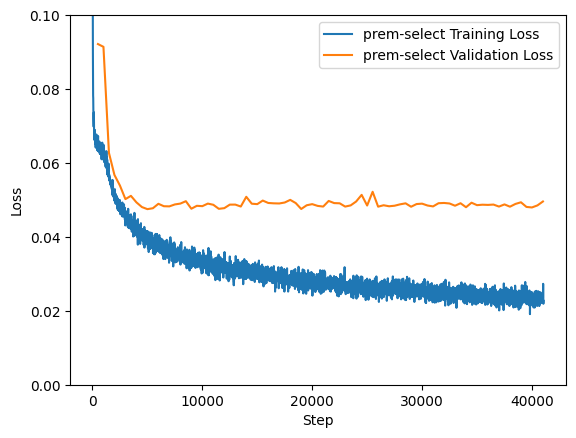

In [6]:
fig, ax = plt.subplots()
for m in MODEL_NAMES:
    train_state_data = get_latest_train_state(MODELS_DIR_PATH, m)
    train_logs = parse_train_longs(train_state_data["log_history"])
    eval_logs = parse_eval_logs(train_state_data["log_history"])
    plot_loss(train_logs, eval_logs, m, ax)